In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
import data, model, interpretation, utils, vis_utils

(251, 64, 64, 64, 1) (251,)
torch.Size([32, 1])


In [3]:
test_data = np.load("test_aug.npy")
test_label = np.load("test_label_aug.npy")

test_data = np.reshape(test_data, (512, 1, 64, 64, 64))

# Initialize pretrained model

In [4]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [5]:
net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])

<All keys matched successfully>

In [6]:
net.eval();

In [7]:
brain_map = vis_utils.load_nifti('aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    area_mask = vis_utils.resize_image(area_mask, (64, 64, 64), interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [8]:
def get_relevance_per_area(relevance_map, normalize=True):
    relevances = np.zeros(len(area_masks))
    print(relevances.shape)
    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)
    if normalize:
        relevances /= relevances.sum()  # make all areas sum to 1

    # Merge left and right areas.
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    return sorted(zip(merged_area_names, merged_relevances), key=lambda x: x[1], reverse=True)

In [9]:
brain_map.shape

(181, 217, 181)

# Sensitivity Analysis

- Loop through all test examples. 
- For each, record whether its label is NC or AD
- get relevance_map_backprop, and record whether it was correctly classified or not
- average relevance_map_backprop[0] at the end across the 4 categories (correct vs wrong classification, NC vs AD label)
- build dict, add up percentages of top 10 (for efficiency) areas -> then take top 5


In [13]:
def merge_dicts(dict_A, dict_B):
  dict_res = {}
  for k, v in dict_A.items():
    dict_res[k] = v
  for k, v in dict_B.items():
    if k in dict_res:
      dict_res[k] += v
    else:
      dict_res[k] = v

  return dict_res

dict_A = {'a': 10, 'b': 5.4}
dict_B = {'b': 1, 'c': 2}
test_merge = merge_dicts(dict_A, dict_B)
print(test_merge)

{'a': 10, 'b': 6.4, 'c': 2}


In [14]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

In [27]:
print(test_data.shape)
print(test_data[58].shape)
print(test_data[59].shape)

(512, 1, 64, 64, 64)
(1, 64, 64, 64)
(1, 64, 64, 64)


In [28]:
# IMPORTANT: RUN TWO CELLS ABOVE TO RE-INIT VARIABLES!! 

import interpretation
import importlib
importlib.reload(interpretation)

for i in range(58, 512):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.sensitivity_analysis(net, test_data[i], cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for area, pct in areas_top_ten.items():
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct



i:  58
Image was classified as 0 with probability 0.9392880015075207
output size:  torch.Size([1, 1])
one hot output:  tensor([[[1.],
         [0.]]])


RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([1, 2, 1]) and output[0] has a shape of torch.Size([1, 1]).

In [ ]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong

dict_AD = merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = merge_dicts(dict_NC_correct, dict_NC_wrong)

In [25]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)
print(dict_NC_correct)

0 0 189 0
{'Temporal_Inf': 11.077706213363996, 'Insula': 9.431793437530073, 'Frontal_Inf_Orb': 9.54318216078661, 'Temporal_Mid': 8.522193835457472, 'Fusiform': 7.072885010995277, 'Temporal_Pole_Mid': 2.7531382298974676, 'Frontal_Inf_Tri': 7.426794955319172, 'Temporal_Pole_Sup': 2.6027668104201473, 'ParaHippocampal': 4.054924726698849, 'Putamen': 6.696985825499114, 'Caudate': 4.589739735596109, 'Cingulum_Ant': 6.751186919527889, 'Temporal_Sup': 2.243166592270606, 'Frontal_Sup_Orb': 0.22759770181299754, 'Rectus': 0.220176736029912, 'Frontal_Mid': 0.5079459325367559}


In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC

-1.1001736853553332 2.533526221248398 1.2700951e-13 7.867203469686603e-06


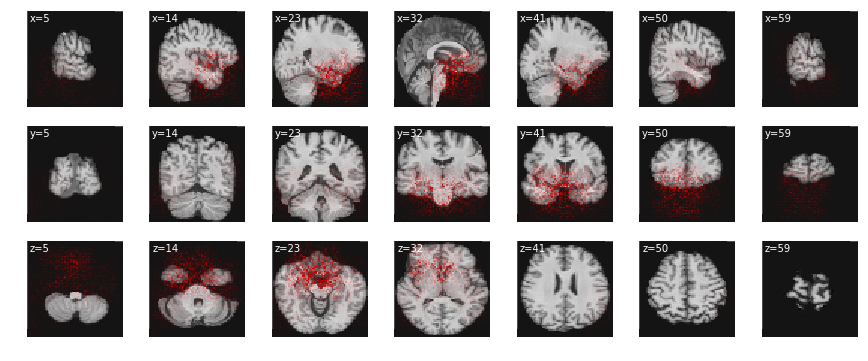

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_AD_correct, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_AD_wrong, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_NC_correct, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_NC_wrong, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_AD, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_NC, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)


In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)


(116,)


[('Temporal_Inf', 0.053981621151635295),
 ('Frontal_Inf_Orb', 0.04933422411682171),
 ('Frontal_Inf_Tri', 0.049313244291932984),
 ('Insula', 0.04887596855375636),
 ('Cingulum_Ant', 0.048765741096707005)]

# Guided Backprop

NC example:

In [0]:
relevance_map_guided_neg = interpretation.guided_backprop(net, test_data[11], cuda=False, verbose=True)

In [0]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_guided_neg[0], 
                  overlay_vmax=np.percentile(relevance_map_guided_neg, 99.9))

In [0]:
get_relevance_per_area(relevance_map_guided_neg[0])[:5]

AD example:

In [0]:
relevance_map_guided_pos = interpretation.guided_backprop(net, test_data[328], cuda=False, verbose=True)

In [0]:
vis_utils.plot_slices(pos_ex, overlay=relevance_map_guided_pos[0], 
                  overlay_vmax=np.percentile(relevance_map_guided_pos, 99.9))

In [0]:
get_relevance_per_area(relevance_map_guided_pos[0])[:5]

# Occlusion

NC example:

In [0]:
relevance_map_occlusion_neg = interpretation.occlusion(net, test_data[11], size=10, stride=5, occlusion_value = 0, cuda=False, resize=True, verbose=True)

In [0]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_occlusion_neg, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [0]:
get_relevance_per_area(relevance_map_occlusion_neg[0])[:5]

In [0]:
relevance_map_occlusion_pos = interpretation.occlusion(net, test_data[328], size=10, stride=5, cuda=False, resize=True, verbose=True)

In [0]:
vis_utils.plot_slices(pos_ex, overlay=relevance_map_occlusion_pos, 
                      overlay_cmap = vis_utils.alpha_to_red_cmap)

In [0]:
get_relevance_per_area(relevance_map_occlusion_pos[0])[:5]

In [0]:
# Plot occlusion patch on image.
occluded_image = train_data[0][0][:, 30, :].copy()
size = 20
occluded_image[10:10+size, 20:20+size] = 0
plt.imshow(occluded_image, cmap='gray')
plt.axis('off')

# Brain Area Occlusion

In [0]:
relevance_map_area_occlusion_neg = interpretation.area_occlusion(net, test_data[11], area_masks, cuda=False, verbose=True)

In [0]:
vis_utils.plot_slices(neg_ex, overlay=relevance_map_area_occlusion_neg, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)

In [0]:
get_relevance_per_area(relevance_map_area_occlusion_neg)[:5]

AD positive:

In [0]:
relevance_map_area_occlusion_pos = interpretation.area_occlusion(net, test_data[328], area_masks, cuda=False, verbose=True)

In [0]:
vis_utils.plot_slices(test_data[328][0], overlay=relevance_map_area_occlusion_pos, overlay_cmap=vis_utils.alpha_to_red_cmap)
#, overlay_vmin=0, overlay_vmax=1)

In [0]:
get_relevance_per_area(relevance_map_area_occlusion_pos)[:5]

In [0]:
test_mod = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [0]:
for child in test_mod.children():
    print("CHILD:")
    for sub in child.children():
        print("SUB:")
        for mini in sub:
            print(mini)
            print("-------------------------------------------------------")